## Week 3 : Logistic Regression 
```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Recap on Logistic Regression
2. Data for Classification Task
3. Classification task evaluation metrics
4. Dealing with data imbalance (self practice)
```

<hr>

In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. The Sigmoid fucnction

$$\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{e^{x} + 1}$$
* **Domain**: \($-∞, +∞$\)
* **Range**: $(0, +1)$
* **Derivative**: $σ'(x) = \sigma(x)(1 - \sigma(x))$

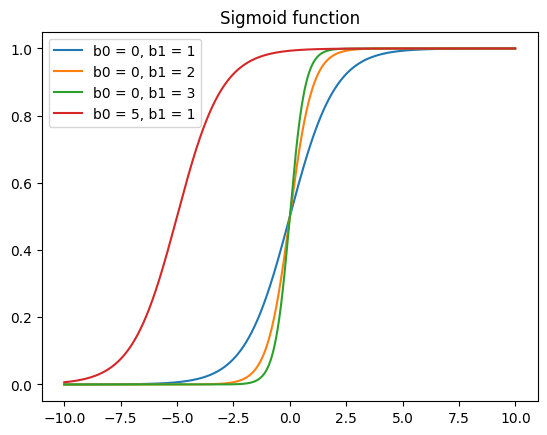

In [3]:
x = np.arange(-10, 10, 0.01)


def plot(b0, b1):
    p = np.exp(b0 + b1 * x) / (1 + np.exp(b0 + b1 * x))
    label = "b0 = {}, b1 = {}".format(b0, b1)
    plt.plot(x, p, label=label)


plot(0, 1)
plot(0, 2)
plot(0, 3)
plot(5, 1)
plt.legend()
plt.title('Sigmoid function')
plt.show()

## 2. Data for Classification Task

* How is data for regression different from classification task different? 

Covid-19 Dataset collected is from March 2020 - November 2021. The target/goal is to predict the disease based on the patient state. 

<strong>Target Feature: Corona Result.</strong>

<strong>Task:</strong> apply the tools of machine learning to predict which patients got infected by Covid-19.

## 3. Load Data

In [4]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///ml-labs-data.db')

with session_engine.connect() as conn:
    covid19_df = pd.read_sql_query(text('SELECT * FROM covid19_lab_sample'), con=conn, parse_dates=['test_date'])

covid19_df.drop('index', axis=1, inplace=True)
covid19_df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,age
0,2021-02-12,0,0,0,0,0,Positive,No,male,Other,51
1,2020-10-14,0,0,0,0,0,Positive,No,male,Other,47
2,2021-02-22,0,0,0,0,0,Positive,No,female,Contact with confirmed,35
3,2021-03-06,1,0,0,0,1,Positive,No,female,Contact with confirmed,37
4,2021-09-24,0,0,0,0,0,Positive,No,female,Contact with confirmed,51


In [5]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            2000 non-null   datetime64[ns]
 1   cough                2000 non-null   int64         
 2   fever                2000 non-null   int64         
 3   sore_throat          2000 non-null   int64         
 4   shortness_of_breath  2000 non-null   int64         
 5   head_ache            2000 non-null   int64         
 6   corona_result        2000 non-null   object        
 7   age_60_and_above     2000 non-null   object        
 8   gender               2000 non-null   object        
 9   test_indication      1781 non-null   object        
 10  age                  2000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 172.0+ KB


## 3.1 Exploratory data analysis (EDA)

An approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods (i.e matplotlib, distribution plot ..)<br> 
Today we are going to try a tool called [ydata-profiling](https://github.com/ydataai/ydata-profiling). It can be easily be installed with:
1. pip: `pip3 install ydata-profiling`  
1. conda: `conda install -c conda-forge ydata-profiling
`

**Note:** All that is done by pandas profilling can be easily be achieved with pandas, matplotlib and numpy

In [6]:
import ydata_profiling

# Create the data profile report
profileReport = ydata_profiling.profile_report.ProfileReport(covid19_df)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# profileReport.to_file('covid_profile.html')

## 3.2 Data preprocessing
1. How to deal with missing values? 
1. How to deal with categorical data? 
1. Is data scaling needed? 

<span style="color:red">TASK: Split data to train and test</span> <br>
<span style="color:red">TASK: Impute missing values</span> <br>
<span style="color:red">TASK: Encode categorical features</span> <br>
<span style="color:red">TASK: Use min-max scaler for feature scaling </span> <br>

In [8]:
# !pip install category-encoders

In [9]:
from sklearn.impute import SimpleImputer
# from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

#Select features 
covid19_df.drop(['test_date'], axis=1, inplace=True)

# Encode the target label 
target_encoding = {'Negative': 0, 'Positive': 1}
covid19_df['corona_result'] = covid19_df['corona_result'].apply(lambda x: target_encoding.get(x))
#covid19_df['corona_result'].describe()
X = covid19_df.drop(columns=['corona_result'])
# Split data to train and test
x_train, x_test, y_train, y_test = train_test_split(X, covid19_df['corona_result'], test_size=.2)

# imputing missing values
imputer = SimpleImputer(strategy='most_frequent')
x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imputer.fit_transform(x_test), columns=x_test.columns)

In [10]:
# encode categorical features
def new_ohe(df, f_name, encoder):
    new_features = encoder.transform(df[f_name])
    new_columns = pd.DataFrame(new_features, dtype=int, columns=encoder.get_feature_names_out(f_name))
    new_df = pd.concat([df, new_columns], axis=1)
    new_df.drop(f_name, axis=1, inplace=True)
    return new_df


features_to_encode = ['test_indication', 'age_60_and_above', 'gender']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(x_train[features_to_encode])

#x_train = encoder.fit_transform(x_train)
x_train = new_ohe(x_train, features_to_encode, encoder)
x_test = new_ohe(x_test, features_to_encode, encoder)

In [11]:
# TODO: feature scaling using MinMaxScaler
scaler = MinMaxScaler()
x_train[:] = scaler.fit_transform(x_train)
x_test[:] = scaler.fit_transform(x_test)

x_train.columns

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'age', 'test_indication_Contact with confirmed',
       'test_indication_Other', 'test_indication_None', 'age_60_and_above_Yes',
       'gender_male'],
      dtype='object')

## 4 Build, Train and Test Model

Now we are ready to see Logistic Regression in practice.

<span style="color:red">Task : Fit Logistic Regression  </span> <br>
<span style="color:red">Task : Output Accuracy, Precision, and Recall scores on test set </span>

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# fit Logistic Regression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Testing accuracy = 0.75
Testing precision = 0.9071428571428571
Testing recall = 0.5934579439252337


## 5. Prediction Results Interpretation & Model perfomence Measurement

1. looking at Logistic Regression Coefficients
2. Prediction threshold

### Task : 
1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them.

In [13]:
# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(x_train.columns), clf.coef_[0])], sep='\n')

----Logistic Regression Coefficients----
('cough', 1.0217965767650479)
('fever', 1.6977171500199526)
('sore_throat', 0.7801575748869283)
('shortness_of_breath', 0.4258834305434485)
('head_ache', 1.5915243141641433)
('age', -0.14568811314098298)
('test_indication_Contact with confirmed', 1.255972982479241)
('test_indication_Other', -0.8490923567892261)
('test_indication_None', -0.6976845280249262)
('age_60_and_above_Yes', -0.07321789547422909)
('gender_male', 0.10286527040196083)


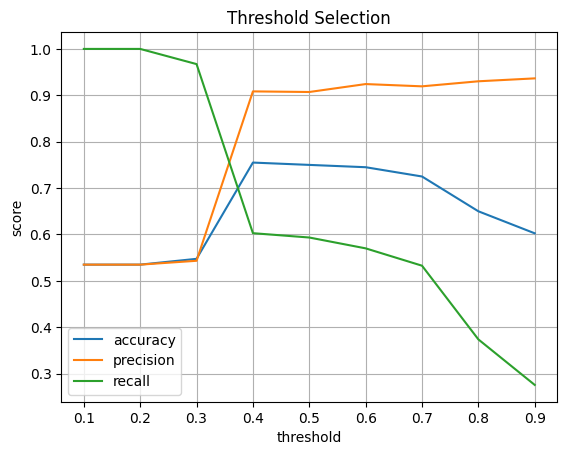

In [14]:
# TODO: calculate metrics for each threshold above and plot the result as below.
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pred_proba = clf.predict_proba(x_test)

results = [[], [], []]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr))  # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr))  # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr))  # recall

plt.plot(thresholds, results[0], label='accuracy')
plt.plot(thresholds, results[1], label='precision')
plt.plot(thresholds, results[2], label='recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

# Confusion matrix

1. Why one may need confusion matrix? 
2. What new information does it show? <br><br>

<table><tr><td>
<img align='center' src='https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg' style='width: 350px;'>
</td><td>
<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_002.png' style='width: 400px;'></td></tr></table>
<br>


<span style="color:red">Task: Implement a confussion matrix method from scratch using python list and numpy</span>

In [15]:
def calc_confusion_matrix(true_labels, pred_labels):
    """Compute confusion matrix to evaluate the accuracy of a classification
    
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    pred_labels : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    """
    num_labels = np.unique(true_labels).size
    cm = np.zeros((num_labels, num_labels), dtype=int)
    for a, p in zip(true_labels, pred_labels):
        cm[a][p] += 1
    return cm

In [16]:
## computing confusion matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
print("Confusion Matrix for Test 1")
print(calc_confusion_matrix(y_true, y_pred))

covid_test_cm = calc_confusion_matrix(y_test, clf.predict(x_test))
print('Confusion Matrix for Covid-19:\n', covid_test_cm, '\n')

Confusion Matrix for Test 1
[[2 0 0]
 [0 0 1]
 [1 0 2]]
Confusion Matrix for Covid-19:
 [[173  13]
 [ 87 127]] 



## <center>Self-Practice  Task</center>

* Using `covid19_self_practice` table dataset given to you.
    1. Split the data to train and test set (80% training). 
    1. Fill missing values
    1. Encode categorical features
    1. Create new features from the existing features
    1. Train a logistic regression model that will predict if a person is infected by COvid-19 `(corona_result)`.
    1. Select the optimal prediction threshold
    1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them. 

https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall

Accuracy is okay when data is balanced
Let’s sum up the accuracy metric!

Pros:

- Accuracy is a helpful metric when you deal with balanced classes and care about the overall model “correctness” and not the ability to predict a specific class. 
- Accuracy is easy to explain and communicate. 
Cons:

If you have imbalanced classes, accuracy is less useful since it gives equal weight to the model’s ability to predict all categories.
Communicating accuracy in such cases can be misleading and disguise low performance on the target class.

In other words, precision answers the question: how often the positive predictions are correct?

In other words, recall answers the question: can an ML model find all instances of the positive class?


In [17]:
with session_engine.connect() as conn:
    new_covid19_df = pd.read_sql_query(text('SELECT * FROM covid19_self_practice'), con=conn, parse_dates=['test_date'])
new_covid19_df.drop(columns=['index', 'medical_id'], inplace=True)
new_covid19_df.info()
# unique, counts = np.unique(new_covid19_df.corona_result, return_counts=True)
# print(dict(zip(unique, counts)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            11000 non-null  datetime64[ns]
 1   cough                11000 non-null  int64         
 2   fever                11000 non-null  int64         
 3   sore_throat          11000 non-null  int64         
 4   shortness_of_breath  11000 non-null  int64         
 5   head_ache            11000 non-null  int64         
 6   corona_result        11000 non-null  object        
 7   age_60_and_above     11000 non-null  object        
 8   gender               10534 non-null  object        
 9   test_indication      10543 non-null  object        
 10  age                  11000 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 945.4+ KB


In [18]:
target_encoding = {'Negative': 0, 'Positive': 1}
Y = new_covid19_df.corona_result.apply(lambda x: target_encoding[x])
new_covid19_df.drop(columns=['corona_result'], inplace=True)

Extract date features and drop `test_date`

In [19]:
date_series = pd.to_datetime(new_covid19_df.test_date)
new_covid19_df['date_year'] = date_series.dt.year
new_covid19_df['date_month'] = date_series.dt.month
new_covid19_df['date_day'] = date_series.dt.day

new_covid19_df.drop(columns=['test_date'], inplace=True)

split data to test and train

In [24]:
x_train, x_test, y_train, y_test = train_test_split(new_covid19_df, Y, test_size=.2)

Impute empty rows

In [26]:
columns_to_impute = ['gender', 'test_indication']
x_train.info()

for col in columns_to_impute:
    x_train_mode = x_train[col].mode()
    x_train[col] = x_train[col].fillna(x_train_mode)
    x_test[col] = x_test[col].fillna(x_train_mode)

<class 'pandas.core.frame.DataFrame'>
Index: 8800 entries, 3990 to 9414
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cough                8800 non-null   int64 
 1   fever                8800 non-null   int64 
 2   sore_throat          8800 non-null   int64 
 3   shortness_of_breath  8800 non-null   int64 
 4   head_ache            8800 non-null   int64 
 5   age_60_and_above     8800 non-null   object
 6   gender               8414 non-null   object
 7   test_indication      8431 non-null   object
 8   age                  8800 non-null   int64 
 9   date_year            8800 non-null   int32 
 10  date_month           8800 non-null   int32 
 11  date_day             8800 non-null   int32 
dtypes: int32(3), int64(6), object(3)
memory usage: 790.6+ KB


In [27]:
from category_encoders import OneHotEncoder

# imputer = SimpleImputer(strategy='most_frequent',missing_values=None)
# x_train[:] = imputer.fit_transform(x_train)
# x_test[:] = imputer.fit_transform(x_test)

columns_to_encode = ['age_60_and_above', 'gender', 'test_indication']

encoder = OneHotEncoder(cols=columns_to_encode).fit(x_train)

x_train: pd.DataFrame = encoder.transform(x_train)

x_test: pd.DataFrame = encoder.transform(x_test)

'''Had error when using custom OHE'''
# encoder = OneHotEncoder(sparse_output=False,drop='first')
# encoder.fit(x_train[columns_to_encode])

# #x_train = encoder.fit_transform(x_train)
# x_train = new_ohe(x_train,columns_to_encode,encoder)
# x_test = new_ohe(x_test,columns_to_encode,encoder)

#x_train.head()
x_train.drop(columns=['test_indication_3', 'gender_2', 'age_60_and_above_2'])
x_test.drop(columns=['test_indication_3', 'gender_2', 'age_60_and_above_2'])

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above_1,gender_1,gender_3,test_indication_1,test_indication_2,test_indication_4,age,date_year,date_month,date_day
7706,0,0,0,0,0,0,1,0,1,0,0,74,2020,11,5
1337,0,0,0,0,1,0,0,0,0,1,0,85,2020,8,21
600,1,0,1,0,0,0,0,1,1,0,0,83,2021,8,5
6719,0,0,0,0,0,1,0,0,1,0,0,36,2021,1,11
5243,0,0,0,0,0,0,1,0,1,0,0,84,2020,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10551,0,0,0,0,0,1,0,0,1,0,0,29,2021,1,14
569,0,0,0,0,0,1,0,1,1,0,0,20,2020,8,28
1100,0,0,0,0,0,1,0,0,1,0,0,37,2021,2,26
4311,0,0,0,0,0,1,1,0,0,1,0,56,2021,1,21


In [28]:
scaler = MinMaxScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [29]:
log_regress = LogisticRegression(random_state=0).fit(x_train, y_train)
y_test_pred = log_regress.predict(x_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Testing accuracy = 0.905
Testing precision = 0.41818181818181815
Testing recall = 0.115


[[0.96364494 0.03635506]
 [0.54946915 0.45053085]
 [0.87015518 0.12984482]
 ...
 [0.92135086 0.07864914]
 [0.57323126 0.42676874]
 [0.95164703 0.04835297]]
{0: 1923, 1: 277}
{0: 1988, 1: 212}
{0: 2062, 1: 138}
{0: 2111, 1: 89}
{0: 2145, 1: 55}
{0: 2167, 1: 33}
{0: 2186, 1: 14}
{0: 2193, 1: 7}
{0: 2199, 1: 1}


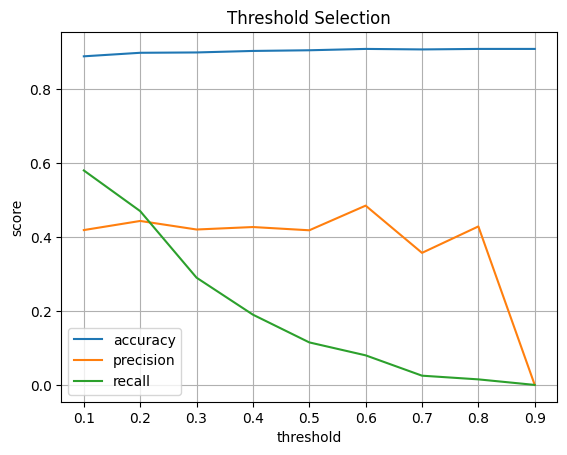

In [30]:
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
pred_proba = log_regress.predict_proba(x_test)
print(pred_proba)

results = [[], [], []]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    unique, counts = np.unique(y_test_pred_thr, return_counts=True)
    print(dict(zip(unique, counts)))
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr))  # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr))  # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr))  # recall

plt.plot(thresholds, results[0], label='accuracy')
plt.plot(thresholds, results[1], label='precision')
plt.plot(thresholds, results[2], label='recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()